# Data Agumentation

In [3]:
import torch
import numpy as np
import random
from torch import nn,tensor
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchmetrics.classification import MulticlassAccuracy 
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import OneCycleLR
from torch.nn import init
import fastcore.all as fc
from lib import *
from pathlib import Path


In [4]:
@inplace
def transformi(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]


def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: # add bias if norm is not a BatchNormLayer
        bias = not isinstance(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: 
        layers.append(norm(nf))
    if act: 
        layers.append(act())
    return nn.Sequential(*layers)

In [5]:
device = "mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
metrics = MetricCB(MulticlassAccuracy(10))
x,y = 'image','labe'
dsd = load_dataset("fashion_mnist")
bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_datasetDict(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

In [6]:
xmean, xstd = 0,0
for xb,_ in dt:
    xmean += xb.mean()
    xstd += xb.std()

xmean /= len(dt)
xstd /= len(dt)


xmean, xstd

(tensor(0.2861), tensor(0.3530))

In [7]:
def normalize(b):
    return (b[0]-xmean)/xstd, b[1]

norm = BatchTransformCB(normalize) 

In [8]:
leak = 0.1
general_leaky_relu = partial(GeneralRelu, leak=leak, subtract=0.4)
astats = ActivationStats(append_stats, fc.risinstance(GeneralRelu)) # get only GeneralRelu # ,
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats] #, norm 
f_init_weights = partial(init_weights, leaky=leak)

In [9]:
set_seed(42)
lr = 6e-2
n_epochs = 3
tmax = n_epochs * len(dls.train)

scheduler = partial(OneCycleLR, total_steps=tmax, max_lr=lr)

epochSched = BatchSchedCB(scheduler)
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats, epochSched]

# Going wider:
If before we went deeper thx to resblocks that were avoiding vanishing/explodings/shattering gradients, now we try to understand what has to be done to widen our cnn

In [ ]:
def get_model(act=nn.ReLU, nfs=[16, 32, 64, 128, 256, 512], norm=None):
    layers = [ResBlock(1, nfs[0], ks=5, act=act, norm=norm, stride=1)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False)]
    layers += [nn.BatchNorm1d(10)] # optional but here works well    
    return nn.Sequential(*layers).to(device)             

In [ ]:
# model = get_model(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)
# learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs, opt_func=optim.Adam)
# learn.lr_find() # too long
# learn.fit(n_epochs)
# astats.plot_all()

# Pooling to support different input shapes
Idea: our cnn is very brittle cuz it cannot take as input images larger than 28x28.
But at the moment we have the restriction of the last linear layer that restricts us to have just the right number of activations as output of the last cnn layer (i.e. the dims of the output of the last cnn layer must be exactly right otheriwise it cannot be flattened for the lin layer)

To solve this we can perform average pooling over the output of the last cnn layer s.t. aggregate 
all the info that is there indipendently of its dims! -> in this case sends all to scalar by taking the mean over each channel.

We can do this by adding a "GlobalAveragePooling"<- keras name; (aka in pytorch is: AdaptiveAveragePoolingLayer). Almost always used to out a 1x1 s.t. make it passable to lin layer.

In [10]:
class GlobalAvgPool(nn.Module):
    def forward(self, x):
        return x.mean((-2,-1)) # collapsw H,W to 1 number, 1 number for each channel
        # cuz we have [bs, ch, h, w] -> [bs, ch] where each obs is composed by ch scalars 

In [ ]:
def get_model2(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
    layers += [nn.Linear(512, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [ ]:
# model = get_model2(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)
# learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs, opt_func=optim.Adam)
# learn.lr_find() # too long
# learn.fit(n_epochs)
# astats.plot_all()

# MEGA-FPLOS
A flops is a Floating-Point-Operation-Per-Second -> approximable as number of multiplications

In [11]:
def _flops(weight, img_h, img_w):
    if weight.dim()<3: return weight.numel() 
    # if lin layer <-> number of moltiplications == number of weigths
    if weight.dim()==4: return weight.numel()*img_h * img_w 
    # in conv case you multiply each weight over the whole grid
    raise Exception()

In [12]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|\n'
    res += '\n'
    totParams, totFlops = 0, 0
    def _f(hook, module, inpt, outpt):
        nonlocal res, totParams, totFlops
        nparms = sum(o.numel() for o in module.parameters())
        *_, height, width = outpt.shape
        flops = sum(_flops(w, height, width) for w in module.parameters())/1e6 # 
        totFlops += flops
        totParams += nparms
        res += f'|{type(module).__name__}|{tuple(inpt[0].shape)}|{tuple(outpt.shape)}|{nparms}|{flops:.1f}|\n'
        res += '\n'
        
    with Hooks(_f, self.model) as hooks:
        self.fit(1, train=False, cbs=[SingleBatchCB()])
    print("Tot params: ", totParams, "MFLOPS:", {totFlops})

    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else:
        print(res)

In [ ]:
model = get_model2(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs, opt_func=optim.Adam)
learn.summary()

Performance do not increase that much so we would like to reduce #weigths and #MFLOPS.
So let's drop 256x512 layer

In [ ]:
def get_model3(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool()]
    layers += [nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers) 

In [ ]:
model = get_model3(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs, opt_func=optim.Adam)
learn.summary()

As we can see we have reduce by a lot the number of params, mflops is diminished but not proportionaly to params. Why? Each of our conv layers now is a residual block, thus it performs 2 conv operations:
1) n_in_channels -> n_out_channels
2) n_out_channels -> n_out_channels
How can we see this?

In [ ]:
[w.shape for w in model[0].parameters()]

[torch.Size([16, 1, 5, 5]),  <- first conv \
 torch.Size([16]),  <- first conv biases \
 torch.Size([16, 16, 5, 5]),  <- second conv \
 torch.Size([16]),  <- second conv biases \
 torch.Size([16, 1, 1, 1]),  <-- shortcut conv \
 torch.Size([16])]  <-- shortcut conv biases

In [ ]:
4903556/1229444 # using only 1/4 of params we can achieve same accuracy

How can we make it faster? The largest # of MFLOPS is |5.3| in the first layer. Let's try to drop the ResBlock there and replace it with traditional conv layer and see which drop of acc we have.
BTW why is it the largest # of MFLOPS even if is the first layer with low num of channels? -> input shape dimensionality! 

In [60]:
def get_model4(act=nn.ReLU, nfs=(16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [12]:
model = get_model4(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs, opt_func=optim.Adam)
learn.summary()

Tot params:  303476 MFLOPS: {9.605347999999998}


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|

|Sequential|(1024, 1, 28, 28)|(1024, 16, 28, 28)|448|0.3|

|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14432|2.8|

|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57536|2.8|

|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229760|3.7|

|GlobalAvgPool|(1024, 128, 4, 4)|(1024, 128)|0|0.0|

|Linear|(1024, 128)|(1024, 10)|1280|0.0|

|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|



## This is important cuz number of params != speed -> you have to evaluate MFLOPS (but you should also factor in ammount of stuff that has to be moved in mem inside the model)

MulticlassAccuracy,loss,epoch,train
0.736,0.861,0,train


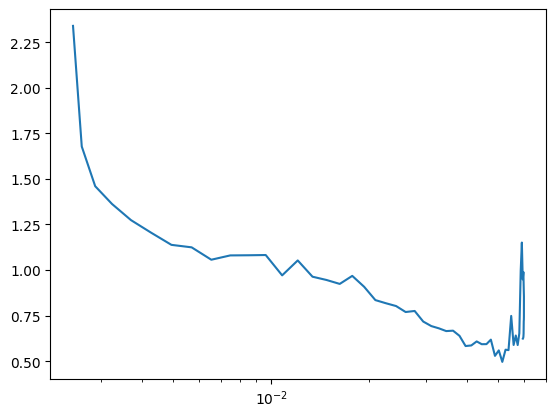

In [13]:
learn.lr_find(max_epochs=1)

# With batchnorm, weight decay doesn't really regularize.

Even by training much more we just overfit train data while keeping the same acc on valid set 
# Data Agumentation

In [13]:
from torchvision import transforms

# let's create a batch transform cb
def tfm_batch(batch, tfm_x=fc.noop, tfm_y=fc.noop):
    ''' applies agumenting function to batch'''
    return tfm_x(batch[0]), tfm_y(batch[1])

# adds padding after crop to make input of same size
tfm_x_train = nn.Sequential(transforms.RandomCrop(28, padding=4),
                           transforms.RandomHorizontalFlip())

# we use a BatchTransformCB that applies
# transforms to batch using a before_batch()
# it passes batch_x thru a  nn.Sequential that acts as a data agumenting pileline
agumentCB = BatchTransformCB(partial(tfm_batch, tfm_x= tfm_x_train), on_validation=False)

In [17]:
model = get_model4(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)

In [18]:
cbs_ = [DeviceCB(), SingleBatchCB(), agumentCB]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs_, opt_func=optim.Adam)

In [ ]:
learn.fit(1)

In [ ]:
xb, yb = learn.batch

In [14]:
def show_img(im, ax=None, figsize=None, title=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figure=figsize)
    ax.imshow(im, **kwargs)
    if title:
        ax.set_title(title)
    ax.axis('off')
    return ax

def showImgGroup(data, grid=(3,3)):
    fig, axs = plt.subplots(grid[0], grid[1])
    imgs = data[: (grid[0]* grid[1] - 1)]
    for ax, img in zip(axs.flat, imgs):
        show_img(img.squeeze(), ax)

In [ ]:
showImgGroup(xb) # a different agumentation for the whole batch is okay since is randomized across batches

In [23]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+[agumentCB], opt_func=optim.Adam)

MulticlassAccuracy,loss,epoch,train
0.601,1.227,0,train
0.568,1.524,0,eval
0.766,0.642,1,train
0.751,0.648,1,eval
0.816,0.502,2,train
0.830,0.472,2,eval


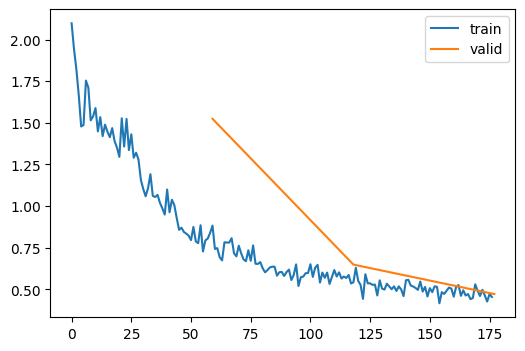

In [24]:
learn.fit(n_epochs)

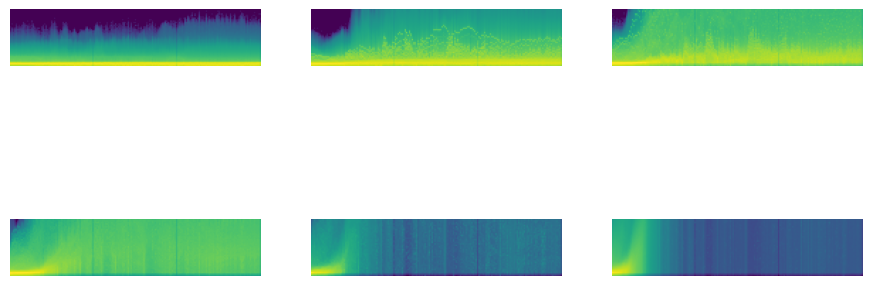

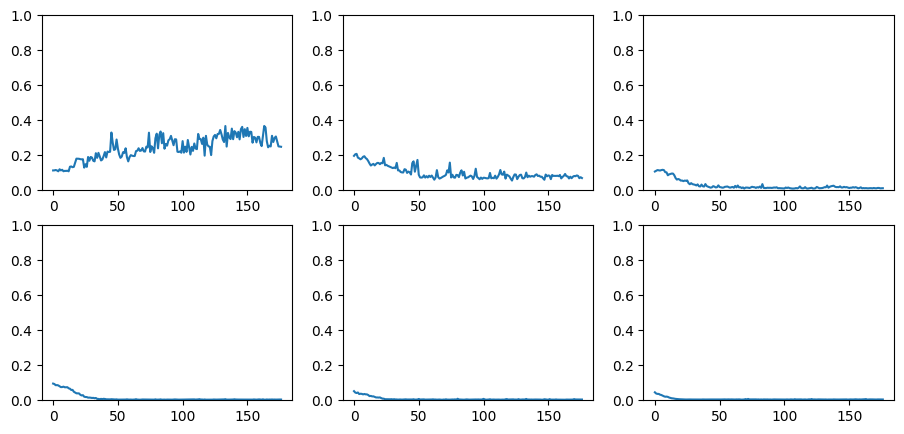

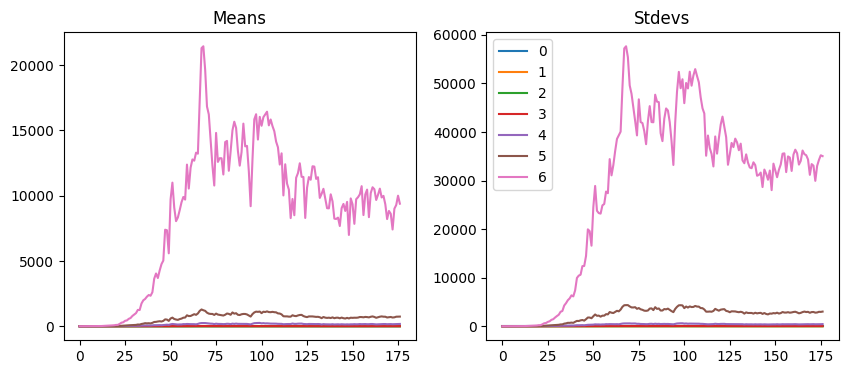

In [25]:
astats.plot_all()

# Saving the model

In [27]:
mdl_path = Path('models') # creates folder model
mdl_path.mkdir(exist_ok=True) # does not crash if path exists
torch.save(learn.model, mdl_path/'data_aug.pkl')

In [22]:
mdl_path = Path('models') # creates folder model
model = torch.load(mdl_path/'data_aug.pkl')
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+[agumentCB], opt_func=optim.Adam)
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (1): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (idconv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (act): GeneralRelu()
  )
  (2): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (idco

# Test Time Augmentation (TTA) 
Does agumentation on validation aswell.
We are going to perform very easy agumentation: horizontal flip.

Why we do so? Given a batch of the valid_set, we can:
1) get prediction for batch from valid_set, and store them
2) apply agumentation to batch from valid_set
3) get prediction for TTAgumented batch from valid_set, and store them
4) average predictions gathered in step1 and step 3 to get "final" predictions

Idea: we "look at an obs from valid set from different perspectives" -> better precision

## Same idea/code can be used to do ensambling with different models or with dropout (2 different dropout models get preds and merge preds) 
If you use dropout for TTA is mostly to see how confident the model is about a prediction cuz if model not so sure even that small change due to dropout will lead to different predictions

In [23]:
class CapturePreds(Callback):
    def before_fit(self, learn):
        self.all_preds, self._all_targets = [], []
        
    def after_batch(self, learn):
        self.all_preds.append(to_cpu(learn.preds)) 
        self._all_targets.append(to_cpu(learn.batch[1])) 

MulticlassAccuracy,loss,epoch,train
0.830,0.472,0,eval


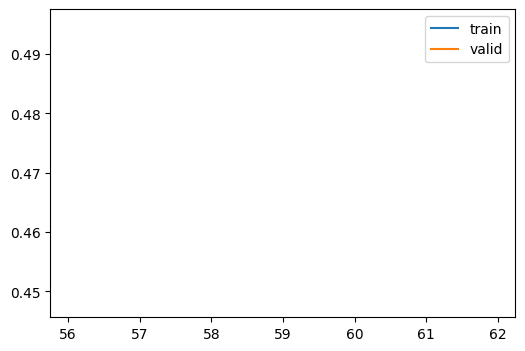

In [24]:
cp = CapturePreds() # without agumentation
learn.fit(1, train=False, cbs=[cp])

MulticlassAccuracy,loss,epoch,train
0.835,0.460,0,eval


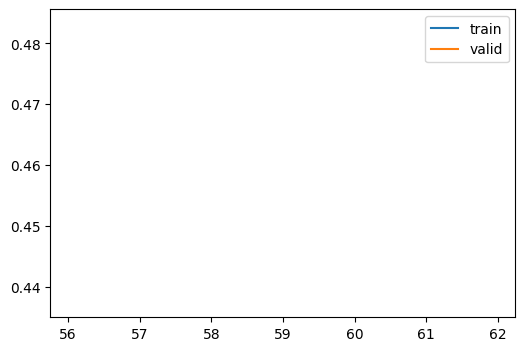

In [25]:
cp2 = CapturePreds()
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_validation=True)
learn.fit(1, train=False, cbs=[cp2, ttacb]) # agument and save preds

In [26]:
ap1 = torch.cat(cp.all_preds)
ap2 = torch.cat(cp2.all_preds)
targets = torch.cat(cp2._all_targets)
ap1.shape, ap2.shape, targets.shape 

(torch.Size([10000, 10]), torch.Size([10000, 10]), torch.Size([10000]))

In [27]:
agumented_predictions = torch.stack([ap1, ap2]).mean(0).argmax(1)

In [28]:
round((agumented_predictions==targets).float().mean().item(), 3) # get accuracy

0.834

# Agumentation technique: Random Ereasing
Drop a little patch out of a picture and replace it with random noise

In [46]:
# get 1 batch
xb, _ = next(iter(dls.train))
xbt = xb[:16]
xbt.min(), xbt.max()

(tensor(0.), tensor(1.))

In [47]:
# get its avg/std
xm, xs = xbt.mean(), xbt.std()
xm, xs
# we cant just drop a patch cuz we would change the statistics of our data, but if we
# replace it with something that has same means/std its ok cuz won't change statistics

(tensor(0.2743), tensor(0.3602))

In [48]:
patch_size = .2 # define % for patch size

In [49]:
# random size and random location
size_x = int(patch_size * xbt.shape[-2]) # take 20% of pic  
size_y = int(patch_size * xbt.shape[-1])

start_x = int(random.random() * (1-patch_size) * xbt.shape[-2])
start_y = int(random.random() * (1-patch_size) * xbt.shape[-1])

In [50]:
init.normal_(xbt[:,:,start_x:start_x+size_x, start_y:start_y+size_y], mean=xm, std=xs)

tensor([[[[ 4.4501e-01,  3.4550e-01,  6.9069e-01,  4.1707e-01, -6.1398e-01],
          [ 4.0475e-01,  4.0989e-01,  2.0914e-01,  4.1583e-01,  4.3012e-01],
          [-2.1657e-01,  7.6284e-01,  5.1515e-01,  1.9354e-02,  1.5659e-01],
          [ 1.7384e-01,  1.2227e-01, -2.0563e-01,  1.4318e-01,  3.2877e-01],
          [ 1.4768e-01, -1.0518e-02,  2.4130e-01,  3.5897e-01,  1.0825e+00]]],


        [[[ 4.8377e-01,  4.3734e-01,  5.0515e-01,  4.6155e-01,  4.7479e-01],
          [ 3.0107e-01,  5.3047e-01,  6.9438e-02,  7.2738e-01, -2.9806e-01],
          [-1.2944e-01,  5.7766e-01,  3.3708e-01, -4.9135e-01,  6.2109e-01],
          [ 5.4785e-01,  5.3876e-01,  3.2646e-02,  1.2619e+00,  4.7481e-01],
          [-1.8336e-02,  7.0520e-01,  5.8450e-01, -2.1855e-01, -4.5183e-03]]],


        [[[ 1.1684e-01,  3.0222e-01, -5.8105e-02,  1.1690e-02,  5.3637e-01],
          [ 2.7169e-01, -7.7963e-02,  6.3588e-01,  2.6535e-01,  3.2730e-01],
          [ 2.2735e-01,  2.2729e-03,  4.5066e-02,  2.7688e-02, -1.88

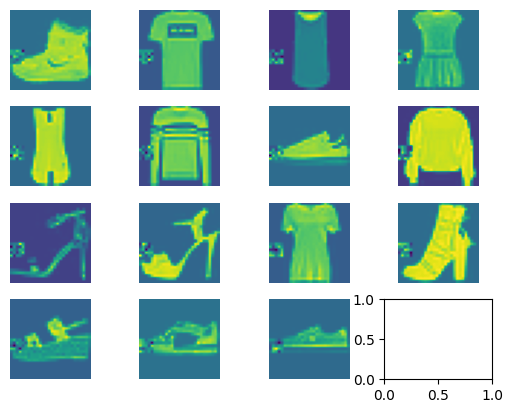

In [51]:
showImgGroup(xbt, (4,4)) # a different agumentation for the whole batch is okay since is randomized across batches

In [38]:
xbt.min(), xbt.max() # care about the range

(tensor(0.), tensor(1.))

In [63]:
def _rand_erase1(x, patch_size, m_min, xs, mn, m_max):
    # random size and random location
    size_x = int(patch_size * x.shape[-2]) # take 20% of pic  
    size_y = int(patch_size * x.shape[-1])

    start_x = int(random.random() * (1-patch_size) * x.shape[-2])
    start_y = int(random.random() * (1-patch_size) * x.shape[-1])
    
    x.clamp_(m_min, m_max)
    
    init.normal_(x[:,:,start_x:start_x+size_x, start_y:start_y+size_y], mean=xm, std=xs)

In [67]:
def rand_erase(x, pct=0.2, max_num = 4):
    xm,xs,mn,mx = x.mean(),x.std(),x.min(),x.max()
    num = random.randint(0, max_num)
    for i in range(num): 
        _rand_erase1(x, pct, xm, xs, mn, mx)
    return x

In [71]:
class RandErase(nn.Module):
    def __init__(self, patch_size=0.2, max_num_of_patches=4):
        super().__init__()
        self.patch_size,self.max_num_of_patches = patch_size,max_num_of_patches
    
    def forward(self, x): 
        return rand_erase(x, self.patch_size, self.max_num_of_patches)

In [72]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_validation=False)

# it is very important to respect the statistics of the data in the replaced patches 

In [73]:
epochs = 5
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
xtra = [BatchSchedCB(sched), augcb]
model = get_model4(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

KeyboardInterrupt: 

# Random Copy
This will for sure matain statistics of the data 

In [76]:
def _rand_copy1(x, pct):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx1 = int(random.random()*(1-pct)*x.shape[-2])
    sty1 = int(random.random()*(1-pct)*x.shape[-1])
    stx2 = int(random.random()*(1-pct)*x.shape[-2])
    sty2 = int(random.random()*(1-pct)*x.shape[-1])
    x[:,:,stx1:stx1+szx,sty1:sty1+szy] = x[:,:,stx2:stx2+szx,sty2:sty2+szy]

(6, 19, 16, 3, 5, 5)

In [ ]:
def rand_copy(x, pct=0.2, max_num = 4):
    num = random.randint(0, max_num)
    for i in range(num): _rand_copy1(x, pct)
#     print(num)
    return x

In [ ]:
class RandCopy(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_copy(x, self.pct, self.max_num)

In [ ]:

tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandCopy())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

# Dropout
Given a vector of probabilities, these probs defines which activations to turn off. Usually is nice to put it after flatten but before linear layer

In [11]:
p = 0.1
# torch.distributions.binomial.Binomial(total_count=1, probs=None, ...)
# total_count (int or Tensor) – number of Bernoulli trials
dist = torch.distributions.binomial.Binomial(probs=1-p) 

dist.sample((10,)) # sample 10 els from the binomial dist, 
# where p is the probability of dropout -> 1-p = probability 
# of keeping the activation alive 

tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1.])

In [12]:
class Dropout(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p
        
    def forward(self, x):
        if not self.training: return x
        # to device to make it faster on gpu
        dist = torch.distributions.binomial.Binomial(tensor(1.0).to(x.device), probs=1-self.p)
        return x * dist.sample(x.size()) * 1/(1-self.p)
    
# as shown in -> tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1.])
# you kill (on avg) 1 activation out of 10 -> 
# whole layer activations are 1/10 smaller so we sclale them up by a 
# factor of 1/(1-self.p) s.t. make the layer back at the same scale

In [13]:
class TTD_CB(Callback):
    def before_epoch(self, learn):
        learn.model.apply(lambda m:m.train() if isinstance(m, (nn.Dropout, nn.Dropout2d)) else None)